In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
words = open("data/names.txt").read().split()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [12]:
chars  = sorted(list(set("".join(words))))
stoi = {char:i+1 for i,char in enumerate(chars)}
stoi["."] = 0
itos = {i:char for char,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [13]:
block_size = 3 

def build_dataset(words):
    
    X,Y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [17]:

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * (5/3) / ((n_embed*block_size)**0.5) #kanning initialization
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
bngain = torch.ones((1, n_hidden) )
bnbias = torch.zeros((1, n_hidden) )
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


tensor(-0.0126) tensor(1.0141)
tensor(0.0038) tensor(1.0267)


(array([9.13649160e-05, 9.13649160e-05, 1.37047374e-04, 1.59888603e-04,
        2.28412290e-04, 5.02507038e-04, 1.14206145e-03, 1.48467989e-03,
        2.76378871e-03, 4.17994491e-03, 6.98941607e-03, 1.10551548e-02,
        1.86841253e-02, 2.77292520e-02, 4.14339894e-02, 6.18997306e-02,
        9.12963923e-02, 1.26654615e-01, 1.70030109e-01, 2.18567720e-01,
        2.78708676e-01, 3.28616762e-01, 3.71695320e-01, 4.05294767e-01,
        4.07830144e-01, 3.96066911e-01, 3.58447407e-01, 3.04039599e-01,
        2.50202822e-01, 1.97736519e-01, 1.50478017e-01, 1.10026200e-01,
        7.60384513e-02, 5.28317627e-02, 3.43760496e-02, 2.18362149e-02,
        1.59431778e-02, 9.25069775e-03, 5.20780021e-03, 3.60891418e-03,
        2.03286938e-03, 1.21058514e-03, 5.93871954e-04, 5.25348267e-04,
        2.51253519e-04, 9.13649160e-05, 4.56824580e-05, 0.00000000e+00,
        2.28412290e-05, 1.14206145e-04]),
 array([-5.31045103, -5.09154862, -4.87264622, -4.65374381, -4.4348414 ,
        -4.215939  , 

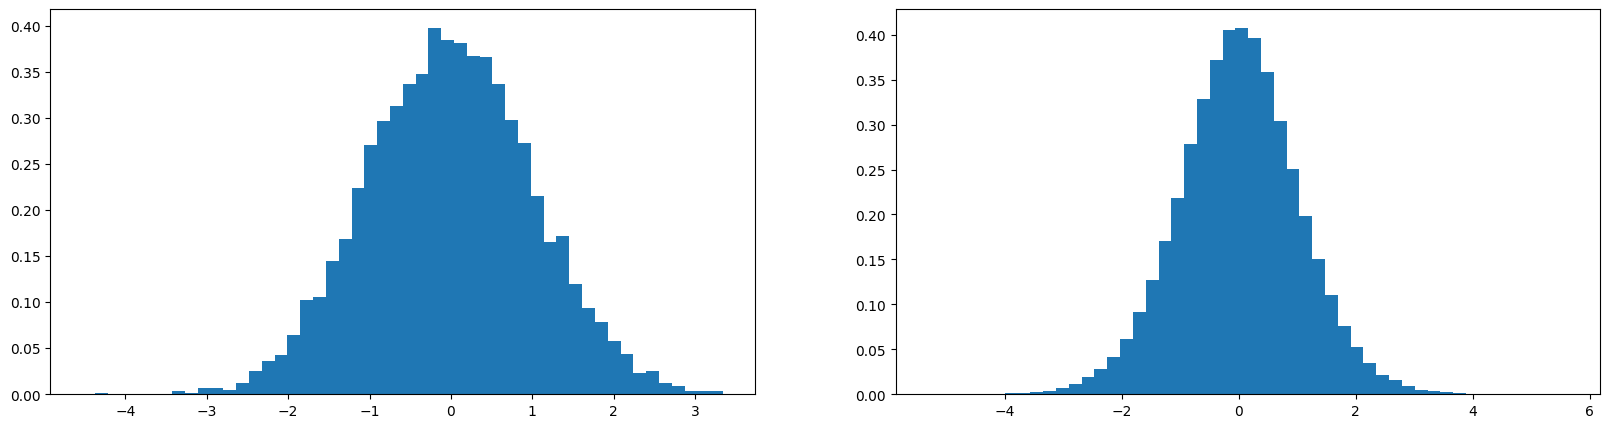

In [18]:
x = torch.randn(1000, 10)
# w = torch.randn(10, 200) * 5 # -> grows the std of y
w = torch.randn(10, 200) / 10**0.5 # -> keeps the std of y
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [19]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # don't need bias because of batch norm
    #batch norm
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #nonlinearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters: 
        p.data += -lr * p.grad
    #stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    

      0/ 200000: 3.3075
  10000/ 200000: 2.0363
  20000/ 200000: 2.5276
  30000/ 200000: 2.4647
  40000/ 200000: 2.3858
  50000/ 200000: 1.8537
  60000/ 200000: 2.1291
  70000/ 200000: 1.7922
  80000/ 200000: 1.9323
  90000/ 200000: 2.0323
 100000/ 200000: 1.7822
 110000/ 200000: 2.2098
 120000/ 200000: 1.9599
 130000/ 200000: 2.6539
 140000/ 200000: 1.7784
 150000/ 200000: 2.2772
 160000/ 200000: 1.9112
 170000/ 200000: 2.0118
 180000/ 200000: 2.0766
 190000/ 200000: 2.0684


In [20]:
# plt.figure(figsize=(20,10))
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [21]:
# plt.hist(h.view(-1).tolist(),50)

In [22]:
# plt.hist(hpreact.view(-1).tolist(),50)

In [23]:
# # we expect
# print(-torch.tensor(1/27).log())

# logits = torch.randn(4)*10
# probs = F.softmax(logits, dim=0)
# loss = -probs[2].log()
# print(logits, probs, loss)

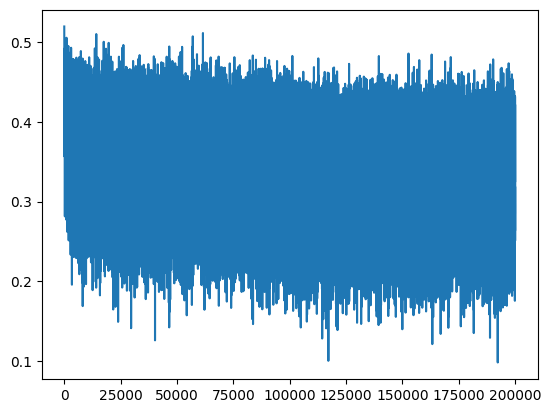

In [24]:
plt.plot(lossi)

In [25]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure mean/std over the entire train set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


In [26]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xva,Yva),
        'test': (Xte,Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain*(hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0694382190704346
val 2.111056327819824


In [27]:
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]  + [ix]
        out.append(ix)
        if ix == 0: break

    print(''.join(itos[i] for i in out))

carlahza.
blllss.
khmrsxfertlanncxsenl.
rahntrferliahth.
gquignnkmarghciaiirdnsleighsh.
matdi.
ffrinnnssoffrannadbi.
wrathftijarisindixespirstimssaffiillatiffhdrriyah.
qinithrissyadimmilsozswynn.
briyannylennkesladln.
gyndeberk.
jazcrynn.
zapllmanranncxeir.
gqiels.
bldaniffertlangbacllyddrkyastllq.
kemlestazlnighnnkhlys.
subriffardtell.
kyam.
bluworgabrkynslowyntricy.
zallyz.


In [126]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0,keepdim=True)
            xvar = x.var(0,keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
        self.out = self.gamma*xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*xmean + self.momentum*self.running_mean
                self.running_var = (1-self.momentum)*xvar + self.momentum*self.running_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1 don't need because of batch norm
    # all other layers apply gain
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3 # could be removed because of batch norm

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


47551


In [127]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad() # for debug

    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = 0.1 if i < 100000 else 0.01
    lr = 1 if i < 100000 else 0.1 #bumb up lr becasue of batch norm
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if i > 1000:
        break # for debug


      0/ 200000: 3.2870


layer 2 (      Tanh): mean +0.02, std 0.63, saturated: 4.25
layer 5 (      Tanh): mean -0.01, std 0.63, saturated: 3.06
layer 8 (      Tanh): mean -0.02, std 0.64, saturated: 3.28
layer 11 (      Tanh): mean -0.01, std 0.63, saturated: 3.09
layer 14 (      Tanh): mean +0.02, std 0.64, saturated: 3.31


Text(0.5, 1.0, 'activation distribution')

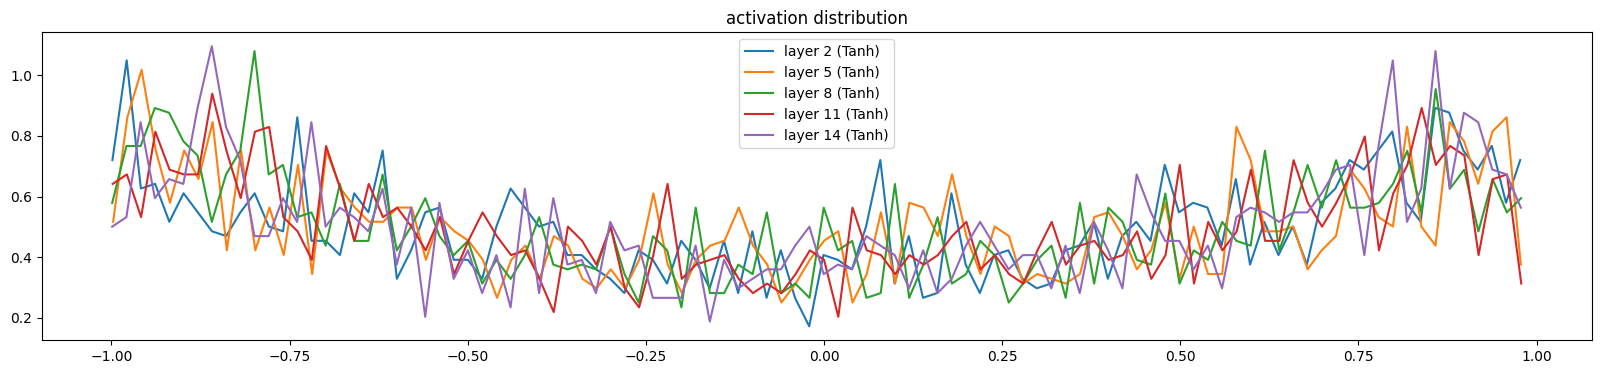

In [128]:
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy,hx = torch.histogram(t, density=True)       
        plt.plot(hx[:-1].detach(), hy.detach())       
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 4.360863e-03
layer 5 (      Tanh): mean +0.000000, std 3.804866e-03
layer 8 (      Tanh): mean -0.000000, std 3.511069e-03
layer 11 (      Tanh): mean +0.000000, std 3.270141e-03
layer 14 (      Tanh): mean -0.000000, std 3.144625e-03


Text(0.5, 1.0, 'gradient distribution')

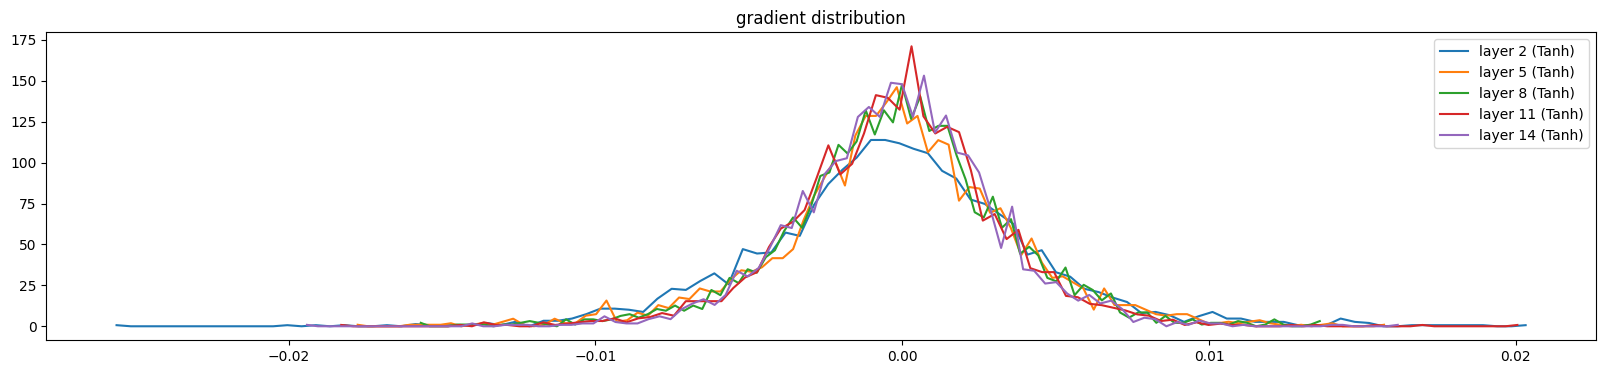

In [129]:
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy,hx = torch.histogram(t, density=True)       
        plt.plot(hx[:-1].detach(), hy.detach())       
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.547100e-03 | grad:data ratio 8.283900e-03
weight  (30, 100) | mean -0.000005 | std 2.678892e-03 | grad:data ratio 2.606676e-03
weight (100, 100) | mean +0.000026 | std 1.376782e-03 | grad:data ratio 1.380236e-03
weight (100, 100) | mean +0.000004 | std 1.260897e-03 | grad:data ratio 1.251008e-03
weight (100, 100) | mean +0.000012 | std 1.097642e-03 | grad:data ratio 1.093700e-03
weight (100, 100) | mean -0.000011 | std 1.066148e-03 | grad:data ratio 1.061357e-03
weight  (100, 27) | mean -0.000035 | std 1.968947e-03 | grad:data ratio 1.988356e-03


Text(0.5, 1.0, 'weights gradient distribution')

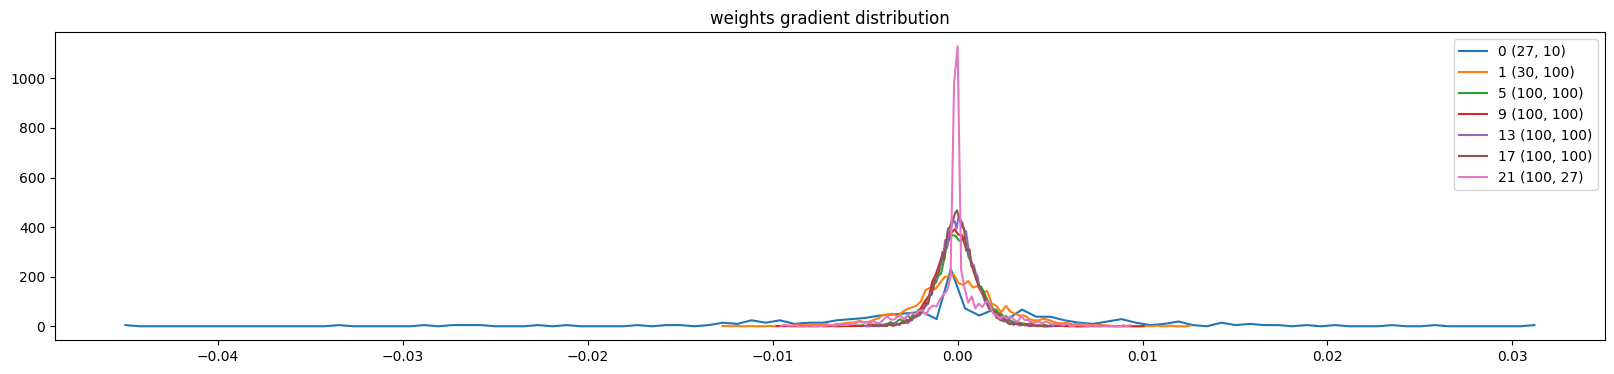

In [130]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), (t.std()/(p.std()))))
        hy,hx = torch.histogram(t, density=True)       
        plt.plot(hx[:-1].detach(), hy.detach())       
        legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution')

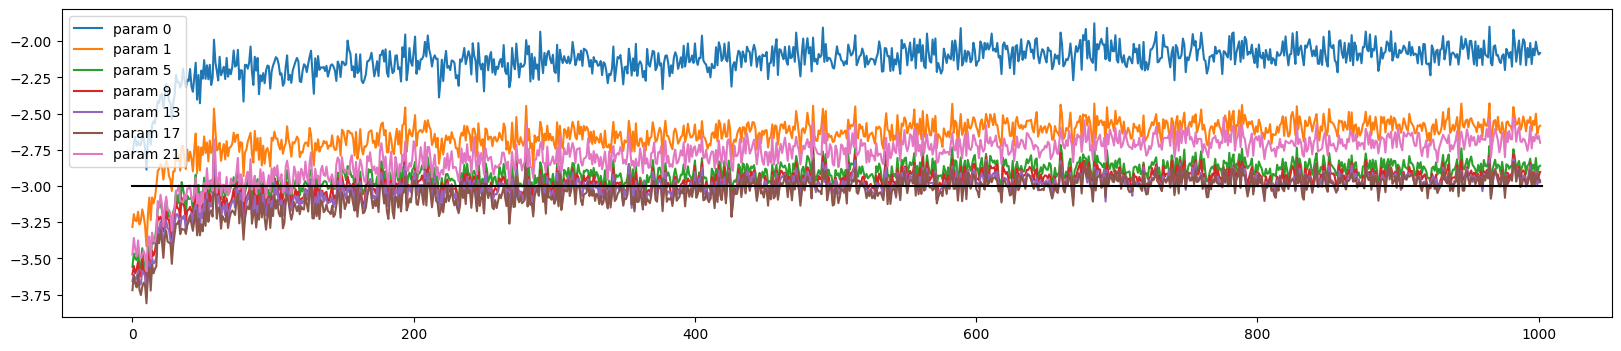

In [131]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)